In [86]:
# load libraries and scripts
import JSON
using Plots
using HDF5
using Trapz
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
#include("../scripts/get_params.jl")
include("../scripts/disturbances.jl")

local_disturbance (generic function with 1 method)

In [87]:
#load borders
border = import_border("../data/border.json")

# create the lattice grid
dx = 20
Nx, Ny, xrange, yrange, isinside, isborder, n = get_grid(border, Float64(dx))

# define x and y coordinate for plotting
x = repeat(reshape(xrange,1,Nx), Ny, 1)
y = repeat(reshape(yrange,Ny,1), 1, Nx);

In [88]:
    data = h5read("../data/pantagruel.h5", "/")
    mg = vec(data["gen_inertia"])
    dg = vec(data["gen_prim_ctrl"])
    idgen = Int64.(vec(data["gen"][:, 1]))
    coord = alberts_projection(
        data["bus_coord"] ./ (180 / pi),
        13.37616 / 180 * pi,
        46.94653 / 180 * pi,
        10 / 180 * pi,
        50 / 180 * pi,
    )
    
    isgrid = isinside .| isborder
    dl = vec(data["load_freq_coef"])
    idb = Int64.(data["branch"][:, 1:2])
    bline = 1 ./ data["branch"][:, 4]

    dem = vec(data["bus"][:, 3]) / 100
    gen = vec(data["gen"][:, 2]) / 100
    
    Nx = length(xrange)
    Ny = length(yrange)
    
    idin = findall(isinside)
    Nbus = length(idin)
    def_val = 1E-2
    m = def_val * ones(Nbus)
    d = def_val * ones(Nbus)
    pl = def_val * ones(Nbus)
    pg = def_val * ones(Nbus)
    lat_coord = zeros(Nbus, 2)
    for i = 1:Nbus
        lat_coord[i, :] = [yrange[idin[i][1]], xrange[idin[i][2]]]
    end
    println(maximum(mg))
    for g in 1:length(idgen)
        k = argmin((lat_coord[:, 2] .- coord[idgen[g],1]).^2 +
            (lat_coord[:, 1] .- coord[idgen[g],2]).^2)
        m[k] += mg[g]
        d[k] += dg[g]
        pg[k] += gen[g]
    end
    
    for l in 1:length(dl)
        k = argmin((lat_coord[:, 2] .- coord[l,1]).^2 +
            (lat_coord[:, 1] .- coord[l,2]).^2)
        d[k] += dl[l]
        pl[k] += dem[l]
    end



    dmax = 100.0
    patch = 1.0
    for l in 1:size(idb,1)
        x2 = coord[idb[l,2], 1]
        x1 = coord[idb[l,1], 1]
        y2 = coord[idb[l,2], 2]
        y1 = coord[idb[l,1], 2] 
        dx_l = x2 - x1
        dy_l = y2 - y1
        ds2 = (dy_l^2 + dx_l^2)
        phi = atan(dy_l, dx_l)
        if(dx_l != 0 && dy_l != 0) # if not a transformer
            x = lat_coord[:, 2] # using node locations instead of centers of lines, 
            y = lat_coord[:, 1] # it's "less precise" but way simpler to implement 
        
            beta = (dx_l .* (y1 .- y) + dy_l .* (x .- x1)) ./ ds2
            alpha = (dx_l .* (x .- x1) + dy_l .* (y .- y1)) ./ ds2
            in_seg = (0 .< alpha) .& (alpha .< 1)
            dist = abs.(beta) .* in_seg .* sqrt(ds2) + # if close to the segment
                .!in_seg .* min.(sqrt.((x .- x1).^2 + (y .- y1).^2), # if close to the ends
                sqrt.((x .- x2).^2 + (y .- y2).^2)) 
            bx[dist .< dmax] .+= bline[l] * abs(cos(phi)) * dx^2 * patch
            by[dist .< dmax] .+= bline[l] * abs(sin(phi)) * dx^2 * patch
        end
    end

    mlat = zeros(Ny, Nx)
    dlat = zeros(Ny, Nx)
    pglat = zeros(Ny, Nx)
    pllat = zeros(Ny, Nx)
    bxlat = zeros(Ny, Nx)
    bylat = zeros(Ny, Nx)
    mlat[isinside] = m
    dlat[isinside] = d
    pglat[isinside] = pg
    pllat[isinside] = pl
    bxlat[isinside] = bx
    bylat[isinside] = by

tau = 0.001 # for heat equation tau=kappa*dt/dx^2
interval = 100
Niter = 5000
mlat_new = zeros(size(mlat))
dlat_new = zeros(size(dlat))
pglat_new = zeros(size(mlat))
pllat_new = zeros(size(dlat))
bxlat_new = zeros(size(dlat))
bylat_new = zeros(size(dlat))
@time begin
    for k in 1:Niter
        
        if(mod(k,interval) == 0)
            temp = copy(mlat)
        end
        
        Threads.@threads for i in 2:Ny-1
            Threads.@threads for j in 2:Nx-1
                if(isinside[i,j])
                    mlat_new[i,j] = (1.0 - 4.0 * tau) * mlat[i,j] + tau * (mlat[i+1,j] +
                        mlat[i-1,j] + mlat[i,j+1] + mlat[i,j-1])
                    dlat_new[i,j] = (1.0 - 4.0 * tau) * dlat[i,j] + tau * (dlat[i+1,j] +
                        dlat[i-1,j] + dlat[i,j+1] + dlat[i,j-1])
                    pglat_new[i,j] = (1.0 - 4.0 * tau) * pglat[i,j] + tau * (pglat[i+1,j] +
                        pglat[i-1,j] + pglat[i,j+1] + pglat[i,j-1])
                    pllat_new[i,j] = (1.0 - 4.0 * tau) * pllat[i,j] + tau * (pllat[i+1,j] +
                        pllat[i-1,j] + pllat[i,j+1] + pllat[i,j-1])
                    bxlat_new[i,j] = (1.0 - 4.0 * tau) * bxlat[i,j] + tau * (bxlat[i+1,j] +
                        bxlat[i-1,j] + bxlat[i,j+1] + bxlat[i,j-1])
                    bylat_new[i,j] = (1.0 - 4.0 * tau) * bylat[i,j] + tau * (bylat[i+1,j] +
                        bylat[i-1,j] + bylat[i,j+1] + bylat[i,j-1])
                end
            end
        end
        
        Threads.@threads for k in 1:size(n,1)
            i = Int64(n[k,1])
            j = Int64(n[k,2])
            nx = n[k,4]
            ny = n[k,3]
            if(nx == 1)
                mlat_new[i,j] = mlat_new[i,j-2]
                dlat_new[i,j] = dlat_new[i,j-2]
                pglat_new[i,j] = pglat_new[i,j-2]
                pllat_new[i,j] = pllat_new[i,j-2]
                bxlat_new[i,j] = bxlat_new[i,j-2]
                bylat_new[i,j] = bylat_new[i,j-2]
            elseif(nx == -1)
                mlat_new[i,j] = mlat_new[i,j+2]
                dlat_new[i,j] = dlat_new[i,j+2]
                pglat_new[i,j] = pglat_new[i,j+2]
                pllat_new[i,j] = pllat_new[i,j+2]
                bxlat_new[i,j] = bxlat_new[i,j+2]
                bylat_new[i,j] = bylat_new[i,j+2]
            end
            if(ny == 1)
                mlat_new[i,j] = mlat_new[i-2,j]
                dlat_new[i,j] = dlat_new[i-2,j]
                pglat_new[i,j] = pglat_new[i-2,j]
                pllat_new[i,j] = pllat_new[i-2,j]
                bxlat_new[i,j] = bxlat_new[i-2,j]
                bylat_new[i,j] = bylat_new[i-2,j]
            elseif(ny == -1)
                mlat_new[i,j] = mlat_new[i+2,j]
                dlat_new[i,j] = dlat_new[i+2,j]
                pglat_new[i,j] = pglat_new[i+2,j]
                pllat_new[i,j] = pllat_new[i+2,j]
                bxlat_new[i,j] = bxlat_new[i+2,j]
                bylat_new[i,j] = bylat_new[i+2,j]
            end
        end
        
        mlat = copy(mlat_new)
        dlat = copy(dlat_new)
        pglat = copy(pglat_new)
        pllat = copy(pllat_new)
        bxlat = copy(bxlat_new)
        bylat = copy(bylat_new)
        
        if(mod(k,interval) == 0)
            #println([k maximum(abs.(mlat-temp))])
            println([k sum(mlat[isinside])])
            #println([k sum(mlat)])
        end
    end
end


2.7792
[100.0 260.42272498553467]
[200.0 258.4445024218221]
[300.0 257.0627553610193]
[400.0 256.05227324353496]
[500.0 255.2827222034676]
[600.0 254.676164498299]
[700.0 254.18433040173426]
[800.0 253.7762212091154]
[900.0 253.43119863830287]
[1000.0 253.13503854550578]
[1100.0 252.87761758142068]
[1200.0 252.651518854571]
[1300.0 252.45116699839215]
[1400.0 252.27227588076556]
[1500.0 252.11148579599933]
[1600.0 251.96611857090562]
[1700.0 251.83400800373795]
[1800.0 251.7133796792521]
[1900.0 251.6027639460436]
[2000.0 251.50093168145978]
[2100.0 251.40684604939958]
[2200.0 251.31962570152916]
[2300.0 251.23851631207833]
[2400.0 251.16286827935355]
[2500.0 251.09211905734443]
[2600.0 251.0257790100394]
[2700.0 250.96341997857397]
[2800.0 250.90466596087384]
[2900.0 250.84918545323768]
[3000.0 250.79668511182933]
[3100.0 250.74690447166816]
[3200.0 250.69961151979308]
[3300.0 250.6545989635962]
[3400.0 250.61168106890074]


LoadError: InterruptException:

0.2115927066669881
0.0031823557717177505


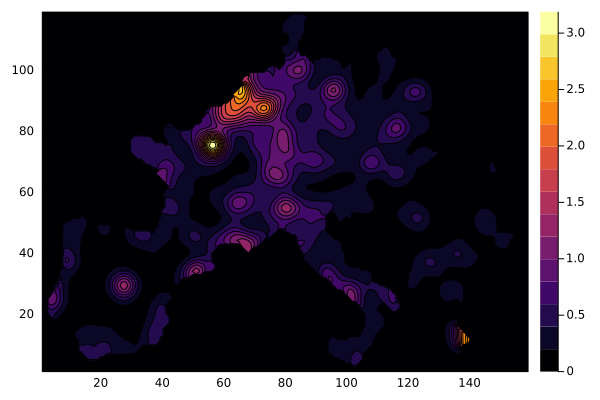

In [89]:
temp = 1 ./ mlat
temp[.!isinside] .= 0
println(maximum(mlat[isinside]))
println(minimum(mlat[isinside]))
contour(pllat, fill=true)
#contour(temp, fill=true)

In [ ]:
contour(pglat, fill=true)

In [ ]:
contour(mlat, fill=true)

In [ ]:
contour(dlat, fill=true)

In [ ]:
contour(dlat ./ mlat, fill=true)

In [ ]:
contour(pglat - pllat, fill=true)

In [77]:
bx = zeros(Nbus)
by = zeros(Nbus)

bx_lat = zeros(Ny, Nx)
bx_lat[isinside] = bx

by_lat = zeros(Ny, Nx)
by_lat[isinside] = by
maximum(bx)
contour(by_lat,fill=true)
minimum(by_lat[isinside])

0.0

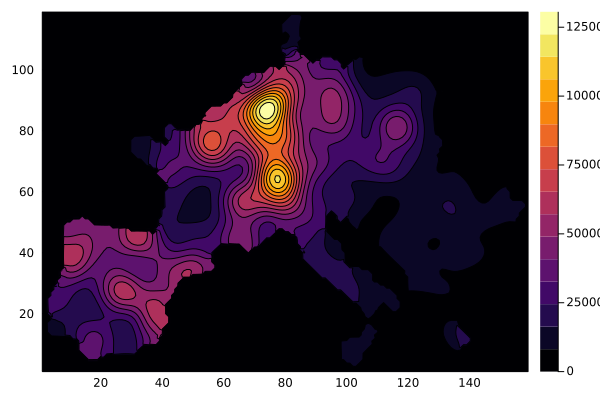

In [84]:
contour(bxlat,fill=true)

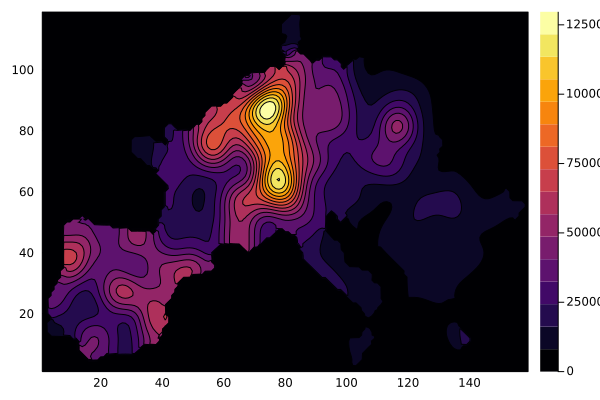

In [85]:
contour(bylat,fill=true)